In [1]:
from scipy.optimize import curve_fit
from scipy import integrate
import matplotlib.pyplot as plt
from control.matlab import *
import pandas as pd
import numpy as np
import os
from control.matlab import *
import control

## Load measured data

0.482578125
0.26318359375


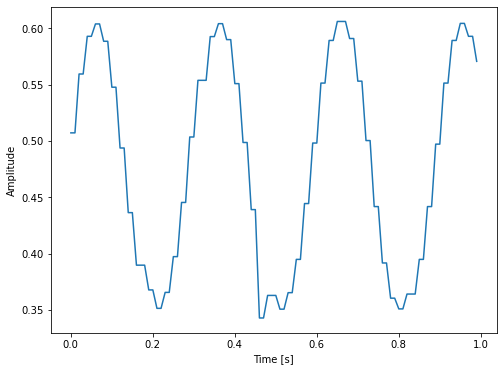

In [2]:
data = pd.read_csv('measurement.csv')
plt.figure(figsize=(8, 6))
steps = data['0'][0:100].shape[0]
x = np.arange(0, steps)
x = x / 100.

plt.plot(x, data['0'][0:100])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
# plt.plot(data['1'][0:100])
print(np.mean(data['0'][0:100]))
print(np.max(data['0'][0:100]) - np.min(data['0'][0:100]))

## Find frequency of measured sine curve

3.4000000000000004
0.9479345703125001


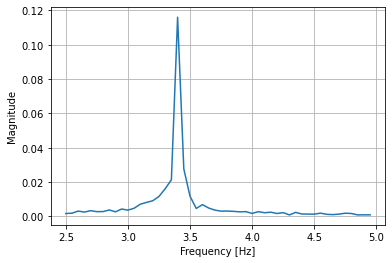

In [3]:
from scipy.fft import fft, fftfreq

N = data['0'].shape[0]
T = 1./100.
yf = fft(data['0'].values)
xf = fftfreq(N, T)[:N//2]

x = xf
y = 2.0/N * np.abs(yf[0:N//2])

print(x[np.argmax(y[50:100]) + 50])

print(np.max(y[:20]))

plt.plot(x[50:100], y[50:100])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

## Find perfectly matching frequency

Since FFT results in "frequency leaking" value estimated earlier was used for initial guess for gradient free optimization method. This also attempt to fine phase shift and amplitude of measured signal.

[3.35953951 0.23990955 0.12704996 0.47401387]


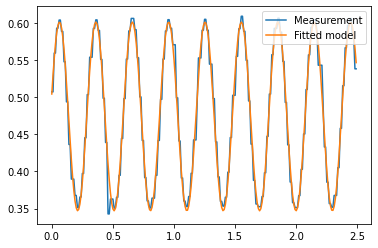

In [4]:
def ident(x, k1, k2, k3, k4):
    return np.sin(x*k1*np.pi*2 + k2) * k3 + k4

y = data['0']
y = y[:250]

steps = y.shape[0]
x = np.arange(0, steps)
x = x / 100.
popt, pcov = curve_fit(ident, x, y, bounds=([3.3, 0.0, 0.0, 0.0], [3.5, np.pi, 0.6, 0.7]))

sine_mag = popt[2]
sine_offset = popt[3]

print(popt)

plt.plot(x, y)
plt.plot(x, ident(x, *popt))
plt.legend(['Measurement', 'Fitted model'], loc='upper right')

## Find frequency of measured cosine curve

Same as before, but for second measured value

3.4000000000000004
0.9479345703125001


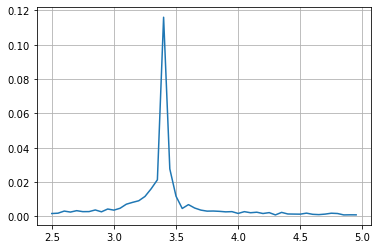

In [5]:
N = data['1'].shape[0]
T = 1./100.
yf = fft(data['0'].values)
xf = fftfreq(N, T)[:N//2]

x = xf
y = 2.0/N * np.abs(yf[0:N//2])

print(x[np.argmax(y[50:100]) + 50])

print(np.max(y[:20]))

plt.plot(x[50:100], y[50:100])
plt.grid()
plt.show()

[3.36419646 0.12268969 0.10126834 0.47636772]


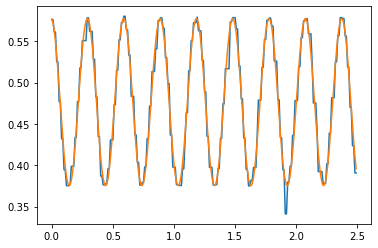

In [6]:
def ident(x, k1, k2, k3, k4):
    return np.cos(x*k1*np.pi*2 + k2) * k3 + k4

y = data['1']
y = y[:250]

steps = y.shape[0]
x = np.arange(0, steps)
x = x / 100.
popt, pcov = curve_fit(ident, x, y, bounds=([3.3, 0.0, 0.0, 0.0], [3.5, np.pi, 0.9, 0.9]))

cosine_mag = popt[2]
cosine_offset = popt[3]

print(popt)

plt.plot(x, y)
plt.plot(x, ident(x, *popt))

In [7]:
print(f'''
sine_offset: {sine_offset}
sine_mag: {sine_mag}

cosine_offset: {cosine_offset}
cosine_mag: {cosine_mag}
''')


sine_offset: 0.47401387187613986
sine_mag: 0.12704995558296325

cosine_offset: 0.47636771811882317
cosine_mag: 0.10126833514930254



## Normalize measured sine and cosine waves

Text(0, 0.5, 'Amplitude')

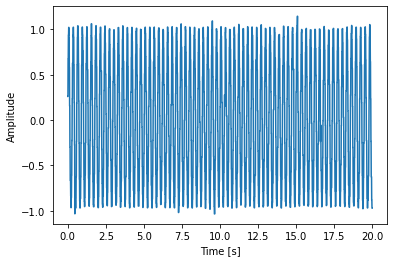

In [8]:
steps = data['0'].shape[0]
x = np.arange(0, steps)
x = x / 100.

sine_std = (data['0'] - sine_offset) / sine_mag

plt.plot(x, sine_std)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')


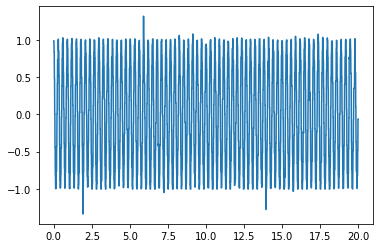

In [9]:
steps = data['0'].shape[0]
x = np.arange(0, steps)
x = x / 100.

cosine_std = (data['1'] - cosine_offset) / cosine_mag

plt.plot(x, cosine_std)

## Reconstruct position function from measurement

3.1351908940183053


Text(0, 0.5, 'Position [rad]')

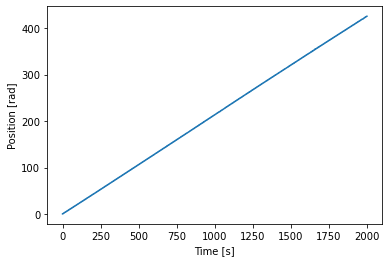

In [10]:
rotation = np.arctan2(sine_std, cosine_std)
sum_rot = [0.0]

last = 0
sum_rot = []
for r in rotation:
    angle = r
    while angle < last-np.pi:
        angle += 2*np.pi
    while angle > last+np.pi:
        angle -= 2*np.pi
    last = angle
    sum_rot.append(angle)

sum_rot = np.array(sum_rot) 

print(np.max(rotation))

plt.plot(sum_rot)
plt.xlabel('Time [s]')
plt.ylabel('Position [rad]')


## Plot current measurement values

0.3703572486482461
0.10540808072207053


Text(0, 0.5, 'Current [A]')

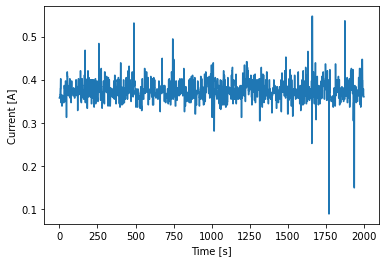

In [11]:
data = pd.read_csv('measurement.csv')
# raw data to voltage
volt = data['2'] / 2**(12) * 3.3
# voltage divider resistors values
r1 = 1166
r2 = 1835
# measured voltage to current
curr = (volt / (r2 / (r1+r2)) - 2.5)*2
print(np.mean(curr[0:100]))
print(np.max(curr[0:100]) - np.min(curr[0:100]))

plt.plot(curr)
plt.xlabel('Time [s]')
plt.ylabel('Current [A]')

As can be seen. Measured current is very noisy and was decided to later not not use it

## Check if model is correct

Compare response of linear system built based on datasheet to measured values

In [12]:
from scipy.optimize import curve_fit
from scipy import integrate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import control as ct
from control import matlab

In [13]:
# Motor parameters obtained from datasheet
import motor_params

In [14]:
mm = motor_params.MotorMechanical()
mp = motor_params.MotorPerformance()
mt = motor_params.MotorThermal()
mw = motor_params.MotorWinding()

A = np.array([
    [-(10.3) / mw.L,  -mw.Ke / mw.L,           0.0],
    [ mw.Kt / mm.Jm, -(mw.Kd) / mm.Jm, 0.0],
    [0.0,            1.0,                      0.0]
])

B = np.array([
    [1.0 / mw.L],
    [0.0],
    [0.0]
])

print(A)
print(B)

[[-3.43333333e+08 -1.59154943e+06  0.00000000e+00]
 [ 1.22307692e+03 -1.22426879e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]]
[[33333333.33333334]
 [       0.        ]
 [       0.        ]]


Text(0.5, 69.0, 'Time [s]')

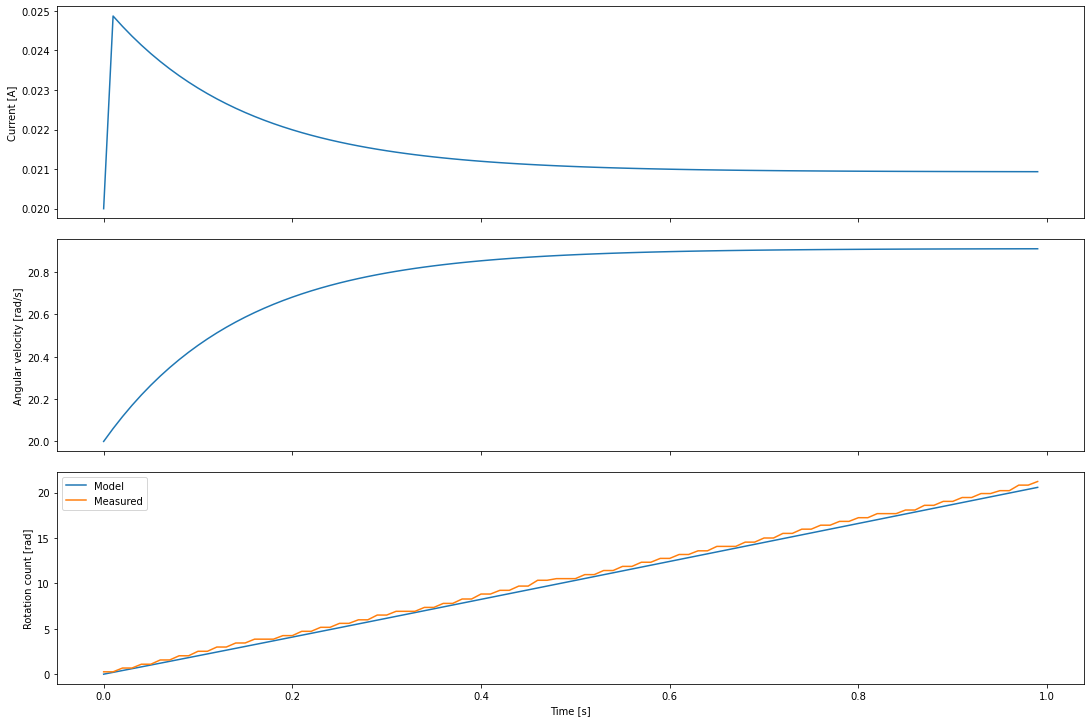

In [15]:
# simulate with time step 0.01 and 20s final time
dt = 0.01
T_d = 20.0

# create time vector
T = np.arange(0, T_d, dt)
xd = np.zeros((T.shape[0], 3))
xk = np.zeros((T.shape[0], 3))

# measurement
xm = np.array(sum_rot)

# measured power supply voltage
Vin = 12.14

# control signal equal to 10% PWM
u = np.ones(len(T)) * Vin * 0.1

# whole state is observable
C = np.identity(3)

# create linear model
sys = ct.matlab.ss(A, B, C, 0)
y, t, _ = lsim(sys, u, T, [0.02, 20, 0])

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(15, 10))
fig.tight_layout()
axs[0].plot(T[:100], y[:,0][:100])
axs[0].set_ylabel('Current [A]')

axs[1].plot(T[:100], y[:,1][:100])
axs[1].set_ylabel('Angular velocity [rad/s]')

axs[2].plot(T[:100], y[:,2][:100])
axs[2].plot(T[:100], xm[:100])
axs[2].set_ylabel('Rotation count [rad]')
axs[2].legend(['Model', 'Measured'])
axs[2].set_xlabel('Time [s]')

## Optimize model parameter

Correct for slight variation in model parameters between dataseet and real motor

In [16]:
def ident(T, mwL, mwKe, mwkt, mwKd, mmJm, R):
    # In every optimization step create new, corrected model
    A = np.array([
        [-R / mwL,      -mwKe / mwL,  0.0],
        [ mwkt / mm.Jm, -mwKd / mmJm, 0.0],
        [0.0,            1.0,         0.0]
    ])

    B = np.array([
        [1.0 / mwL],
        [0.0],
        [0.0]
    ])

    u = np.ones(len(T)) * Vin * 0.1
    C = np.identity(3)
    sys = ct.matlab.ss(A, B, C, 0)
    y, _, _ = lsim(sys, u, T, [0, 0, 0])
    x0 = y[-1]
    x0[-1] = 0.0

    C = np.zeros((1,3))
    C[0,-1] = 1.0
    sys = ct.matlab.ss(A, B, C, 0)

    # simulate response and return it as solution
    y, _, _ = lsim(sys, u, T, x0)
    return y

mwL = mw.L
mwKe = mw.Ke
mwkt = mw.Kt
mwKd = mw.Kd
mmJm = mm.Jm
R = 10.3

dt = 0.01
T_d = 20.0
T = np.arange(0, T_d, dt)

# Create bounded optimization problem
# Boundary values are set to be close to real-world feasible parameters of motor
popt, pcov = curve_fit(ident, T, xm, bounds=(
    [mwL*0.2, mwKe*0.9, mwkt*0.9, mwKd*0.9, mmJm*0.9, R*0.9],
    [mwL*1.0, mwKe*1.1, mwkt*1.1, mwKd*1.1, mmJm*1.1, R*1.1]
))

print(popt)

[1.91846631e-08 4.69714801e-02 4.84741978e-02 4.69578035e-05
 3.96462800e-05 1.03738758e+01]


## Plot new, updated model response

Text(0.5, 24.0, 'Time [s]')

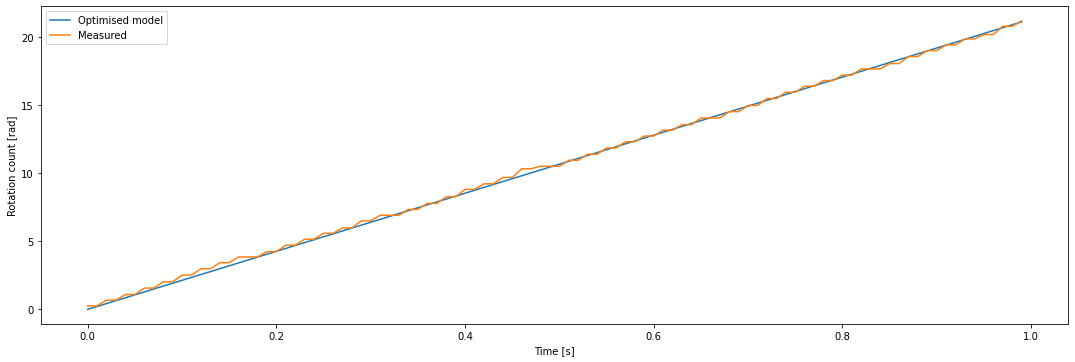

In [17]:
def simulate(T, mwL, mwKe, mwkt, mwKd, mmJm, R):
    A = np.array([
        [-R / mwL, -mwKe / mwL,  0.0],
        [ mwkt / mm.Jm, -mwKd / mmJm, 0.0],
        [0.0,            1.0,         0.0]
    ])

    B = np.array([
        [1.0 / mwL],
        [0.0],
        [0.0]
    ])


    u = np.ones(len(T)) * Vin * 0.1
    C = np.identity(3)
    sys = ct.matlab.ss(A, B, C, 0)
    y, t, _ = lsim(sys, u, T, [0, 0, 0])
    x0 = y[-1]
    x0[-1] = 0.0

    y, t, _ = lsim(sys, u, T, x0)
    return y


dt = 0.01
T_d = 20.0
T = np.arange(0, T_d, dt)
y = simulate(T, *popt)

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 10/2))
fig.tight_layout()

axs.plot(T[:100], y[:,2][:100])
axs.plot(T[:100], xm[:100])
axs.set_ylabel('Rotation count [rad]')
axs.legend(['Optimised model', 'Measured'])
axs.set_xlabel('Time [s]')

## Plot how much values differ after optimization

Red means how many percent value decreased, blue how much it increased. Surprisingly Ke, Kt, Kd and Jm seems to be correlated

[-36.051123    -1.62316219   1.62305627  -1.65180626   1.65712823
   0.71724119]


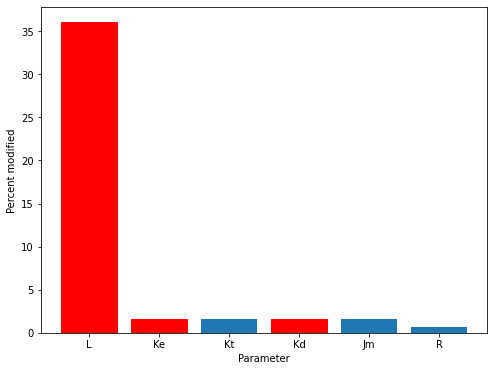

In [18]:
params = np.array([mwL, mwKe, mwkt, mwKd, mmJm, R])
percent = (np.array(popt) - params) / params * 100.0
print(percent)
names = ['L', 'Ke', 'Kt', 'Kd', 'Jm', 'R']

plt.figure(figsize=(8, 6))
barlist = plt.bar(names, np.abs(percent))
for i in range(len(percent)):
    if percent[i] < 0:
        barlist[i].set_color('r')

plt.ylabel('Percent modified')
plt.xlabel('Parameter')
plt.show()

## Kalman filter

Simple, linear Kalman Filter implementation

In [19]:
class KalmanFilter:
    def __init__(self, A, B, C, Q, R, x0=None):
        self._A = np.matrix(A)
        self._B = np.matrix(B)
        self._C = np.matrix(C)
        self._Q = np.matrix(Q)
        self._R = np.matrix(R)
        self._P = np.zeros(A.shape[0])
        if x0 is None:
            self._x = np.zeros((A.shape[0],1))
        else:
            self._x = np.array(x0)
            self._x = self._x.reshape((A.shape[0],1))

    def __call__(self, y, u):
        y = np.matrix(y).T
        u = np.matrix(u).T
        x_hat = self._A @ self._x + self._B @ u
        P_hat = self._A @ self._P @ self._A.T + self._Q
        y_hat = y - self._C @ x_hat
        S = self._C @ P_hat @ self._C.T + self._R
        K = P_hat @ self._C.T @ np.linalg.inv(S)
        self._x = x_hat + K @ y_hat
        self._P = (np.identity(K.shape[0]) - K @ self._C) @ P_hat

    @property
    def x(self):
        return self._x

In order to test KF implementation system was initialized at 0 state vector and later ran to see if it converges.

Text(0.5, 69.0, 'Time [s]')

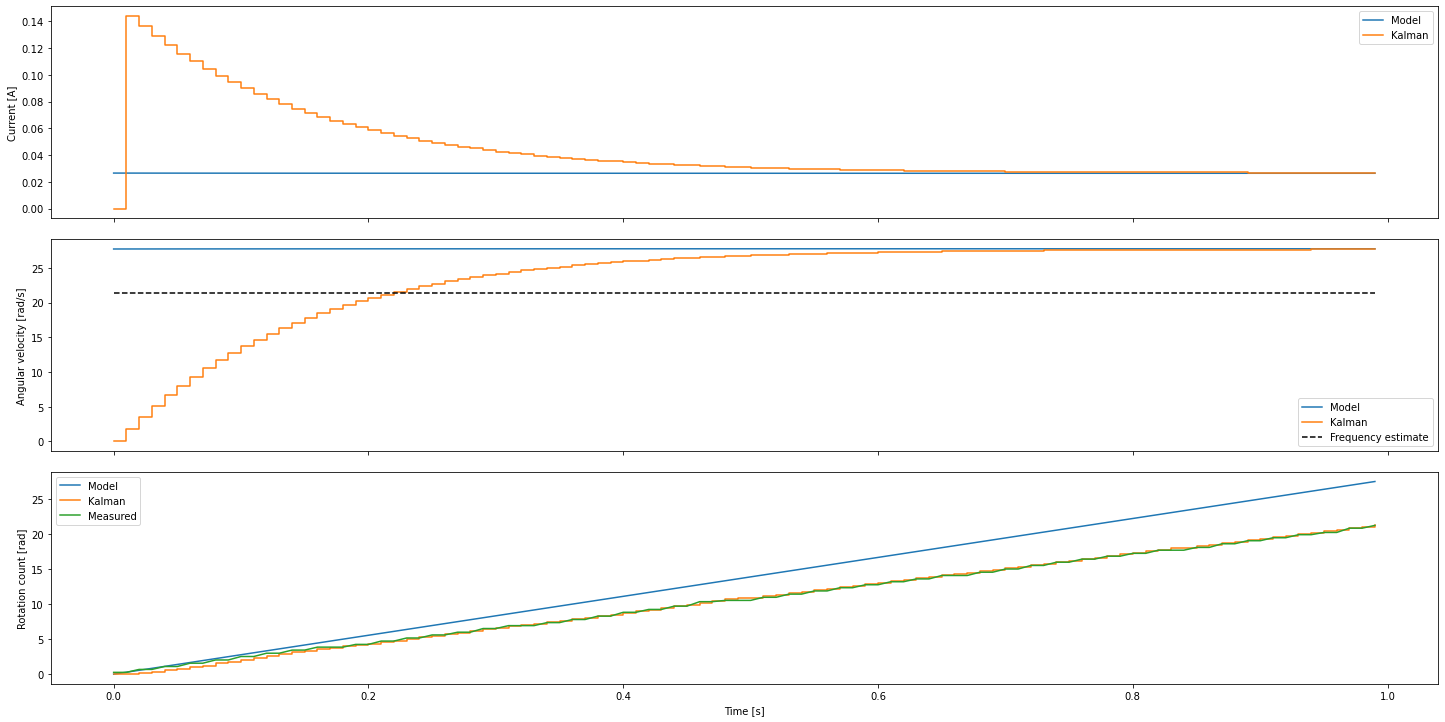

In [20]:
dt = 0.01
T_d = 1.0

mwL  = popt[0]
mwKe = popt[1]
mwkt = popt[2]
mwKd = popt[3]
mmJm = popt[4]
R    = popt[5]

A = np.array([
    [-R / mwL, -mwKe / mwL,  0.0],
    [ mwkt / mm.Jm, -mwKd / mmJm, 0.0],
    [0.0,            1.0,         0.0]
])

B = np.array([
    [1.0 / mwL],
    [0.0],
    [0.0]
])


# create discrete system with only last variable observable
# first and second one are estimated
C = np.zeros((1,3))
C[0,-1] = 1.0
sys = ct.matlab.ss(A, B, C, 0)
sysd = ct.matlab.c2d(sys, Ts=dt, method='zoh')

# hand picked covariances
Q = np.identity(A.shape[0]) * 0.01
R = np.identity(C.shape[0]) * 0.1
kf = KalmanFilter(sysd.A, sysd.B, sysd.C, Q, R)

T = np.arange(0, T_d, dt)
xd = np.zeros((T.shape[0], 3))
xk = np.zeros((T.shape[0], 3))

# measured values
xm = np.array(sum_rot)

# control signal
u = np.ones(len(T)) * Vin * 0.13

# hacky way to archive steady state values to simulate response staring at steady state
C = np.identity(3)
sys = ct.matlab.ss(A, B, C, 0)
y, t, _ = lsim(sys, u, T, [0, 0, 0])
x0 = y[-1]
x0[-1] = 0.0

# simulate system starting at steady state
C = np.identity(3)
sys = ct.matlab.ss(A, B, C, 0)
y, t, _ = lsim(sys, u, T, x0)

# reconstruct state vector using KF
for i in range(1, len(T)):
    kf(xm[i], u[i])
    xk[i,:] = np.squeeze(kf.x)

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20, 10))
fig.tight_layout()
axs[0].plot(T, y[:,0])
axs[0].step(T, xk[:,0], where='post')
axs[0].set_ylabel('Current [A]')
axs[0].legend(['Model', 'Kalman'])

axs[1].plot(T, y[:,1])
axs[1].step(T, xk[:,1], where='post')
axs[1].plot(T, np.ones(len(T))*3.4*np.pi*2, 'k--')
axs[1].set_ylabel('Angular velocity [rad/s]')
axs[1].legend(['Model', 'Kalman', 'Frequency estimate'])

axs[2].plot(T, y[:,2])
axs[2].step(T, xk[:,2], where='post')
axs[2].plot(T, xm[:len(T)])
axs[2].set_ylabel('Rotation count [rad]')
axs[2].legend(['Model', 'Kalman', 'Measured'])
axs[2].set_xlabel('Time [s]')


## "learning based" method to find optimal KF paramters

In order to find best covariance matrices for KF same optimization was used. In this attempt the goal was to try to reconstruct velocity based on position measurement. The position measurement did not match predictions from state equation. This was meant to find matrices that can handle system disturbances.

In [21]:
dt = 0.01
T_d = 10.0

# create state model
mwL  = popt[0]
mwKe = popt[1]
mwkt = popt[2]
mwKd = popt[3]
mmJm = popt[4]
R    = popt[5]

A = np.array([
    [-R / mwL, -mwKe / mwL,  0.0],
    [ mwkt / mm.Jm, -mwKd / mmJm, 0.0],
    [0.0,            1.0,         0.0]
])

B = np.array([
    [1.0 / mwL],
    [0.0],
    [0.0]
])

# observe only position
C = np.zeros((1,3))
C[0,-1] = 1.0
sys = ct.matlab.ss(A, B, C, 0)
sysd = ct.matlab.c2d(sys, Ts=dt, method='zoh')

# create time and state vectors
T = np.arange(0, T_d, dt)
xd = np.zeros((T.shape[0], 3))
xk = np.zeros((T.shape[0], 3))

# control input is slightly bigger than before leading to incorrect state predictions
u = np.ones(len(T)) * Vin * 0.105
# initial state is steady state
x0 = [0.02, 3.4*np.pi*2, 0.0]


def ident_kf(T, Q0, Q1, Q2, R0):
    # compose process noise covariance matrix
    Q = np.identity(A.shape[0])
    Q[0,0] = Q0
    Q[1,1] = Q1
    Q[2,2] = Q2
    # compose observation noise covariance matrix
    R = np.identity(C.shape[0]) * R0
    kf = KalmanFilter(sysd.A, sysd.B, sysd.C, Q, R, x0)

    xk = np.zeros((T.shape[0], 3))

    # simulate KF
    for i in range(0, len(T)):
        kf(xm[i], u[i])
        xk[i,:] = np.squeeze(kf.x)

    # return predicted velocity
    return xk[:,1]


# find optimal Q and R
popt_kf, _ = curve_fit(ident_kf, T, np.ones(len(T))*3.4*np.pi*2, bounds=(
    [0.000001, 0.000001, 0.000001, 0.000001],
    [100000.0, 100000.0, 100000.0, 100000.0]
))

print(popt_kf)

[5.00000000e+04 7.61244286e+04 1.00000000e-06 1.56327978e+04]


## Plot resulting KF

Text(0.5, 69.0, 'Time [s]')

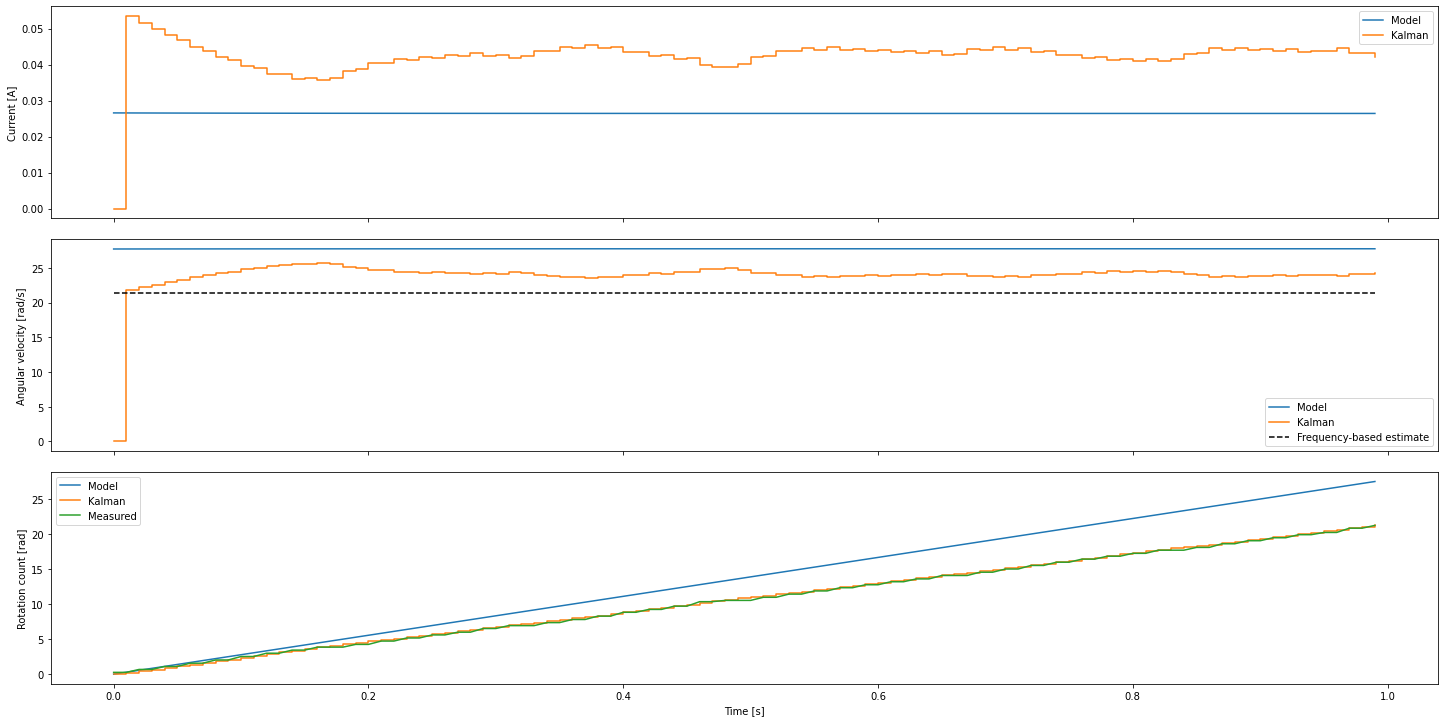

In [22]:
dt = 0.01
T_d = 1.0

# compose model
mwL  = popt[0]
mwKe = popt[1]
mwkt = popt[2]
mwKd = popt[3]
mmJm = popt[4]
R    = popt[5]

A = np.array([
    [-R / mwL,      -mwKe / mwL,  0.0],
    [ mwkt / mm.Jm, -mwKd / mmJm, 0.0],
    [0.0,            1.0,         0.0]
])

B = np.array([
    [1.0 / mwL],
    [0.0],
    [0.0]
])

# create discrete system for KF
C = np.zeros((1,3))
C[0,-1] = 1.0
sys = ct.matlab.ss(A, B, C, 0)
sysd = ct.matlab.c2d(sys, Ts=dt, method='zoh')


# initialise KF with optimized covariances
Q = np.identity(A.shape[0])
Q[0,0] = popt_kf[0]
Q[1,1] = popt_kf[1]
Q[2,2] = popt_kf[2]
R = np.identity(C.shape[0]) * popt_kf[3]
x0 = [0.02, 3.4*np.pi*2, 0.0]
kf = KalmanFilter(sysd.A, sysd.B, sysd.C, Q, R, x0)

# create time and state memory vectors
T = np.arange(0, T_d, dt)
xd = np.zeros((T.shape[0], 3))
xk = np.zeros((T.shape[0], 3))

# measured value
xm = np.array(sum_rot)

# control signal resulting in mismatch between measurement and prediction
u = np.ones(len(T)) * Vin * 0.13

# create LTI with hacky steady state value
C = np.identity(3)
sys = ct.matlab.ss(A, B, C, 0)
y, t, _ = lsim(sys, u, T, [0, 0, 0])
x0 = y[-1]
x0[-1] = 0.0

C = np.identity(3)
sys = ct.matlab.ss(A, B, C, 0)
y, t, _ = lsim(sys, u, T, x0)

# simulate KF
for i in range(1, len(T)):
    kf(xm[i], u[i])
    xk[i,:] = np.squeeze(kf.x)

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20, 10))
fig.tight_layout()
axs[0].plot(T, y[:,0])
axs[0].step(T, xk[:,0], where='post')
axs[0].set_ylabel('Current [A]')
axs[0].legend(['Model', 'Kalman'])

axs[1].plot(T, y[:,1])
axs[1].step(T, xk[:,1], where='post')
axs[1].plot(T, np.ones(len(T))*3.4*np.pi*2, 'k--')
axs[1].set_ylabel('Angular velocity [rad/s]')
axs[1].legend(['Model', 'Kalman', 'Frequency-based estimate'])

axs[2].plot(T, y[:,2])
axs[2].step(T, xk[:,2], where='post')
axs[2].plot(T, xm[:len(T)])
axs[2].set_ylabel('Rotation count [rad]')
axs[2].legend(['Model', 'Kalman', 'Measured'])
axs[2].set_xlabel('Time [s]')

As can be seen KF stared converging and was trying to reconstruct real angular velocity based on measurement, at the same time trying to follow state model.

# LQR

Implementation of LQR on given identified system

/tmp/ipykernel_92033/972436660.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([


Text(0.5, 69.0, 'Time [s]')

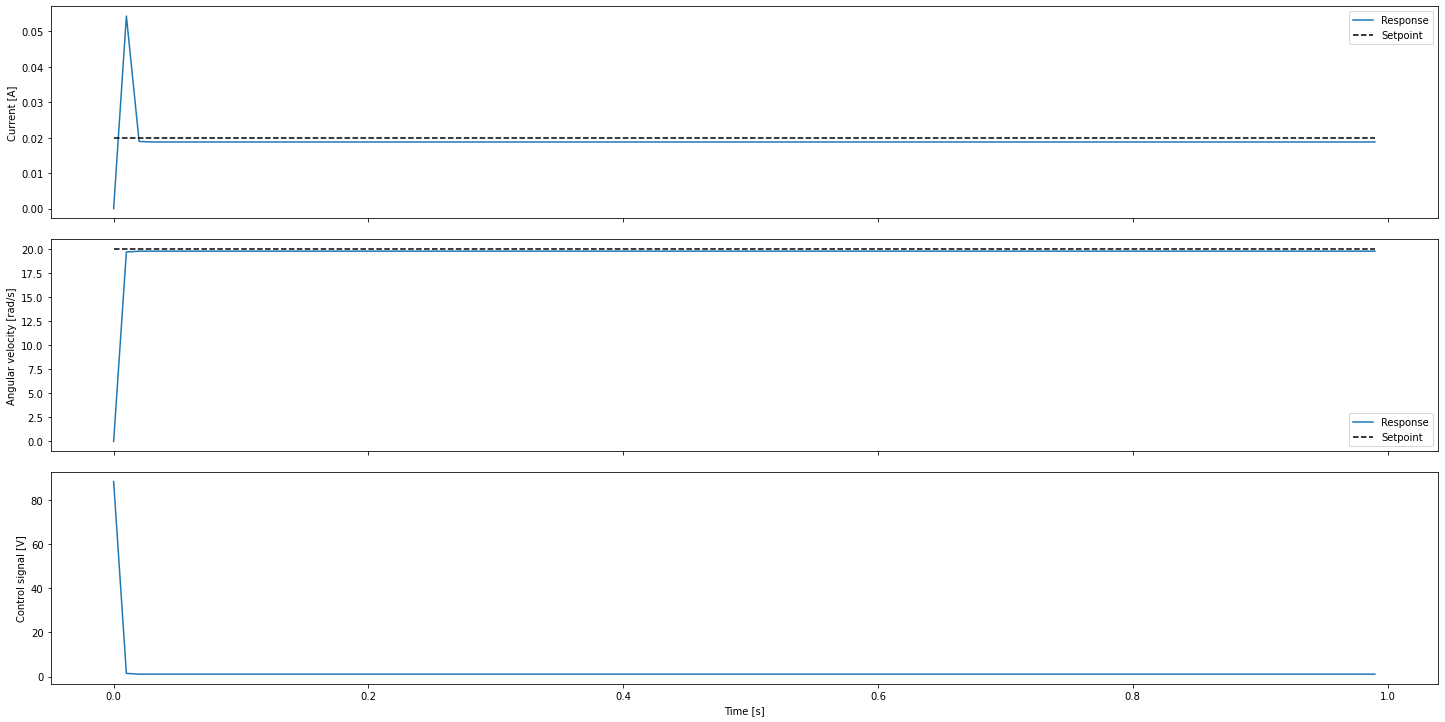

In [24]:
dt = 0.01
T_d = 1.0
T = np.arange(0, T_d, dt)

# create LTI
A = np.array([
    [-R / mwL,      -mwKe / mwL ],
    [ mwkt / mm.Jm, -mwKd / mmJm]
])


B = np.array([
    [1.0 / mwL],
    [0.0]
])

C = np.identity(2)

sys = ct.matlab.ss(A, B, C, 0)

# fill LQR weights
Q = np.identity(2)
Q[0,0] = 20.0
Q[1,1] = 200.0
R = np.ones(1) * 10.0

# compute K matrix
K, S, E = lqr(sys, Q, R)

# create feedback look
ksys = ct.matlab.series(K, sys)
fsys = ct.matlab.feedback(ksys, np.identity(2))

# simulate system
u = np.ones((len(T), 2))
u[:,0] = 0.02
u[:,1] = 20.0
y, t, _ = lsim(fsys, u, T)


fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20, 10))
fig.tight_layout()
axs[0].plot(T, y[:,0])
axs[0].plot(T, u[:,0], 'k--')
axs[0].legend(['Response', 'Setpoint'])
axs[0].set_ylabel('Current [A]')

axs[1].plot(T, y[:,1])
axs[1].plot(T, u[:,1], 'k--')
axs[1].legend(['Response', 'Setpoint'])
axs[1].set_ylabel('Angular velocity [rad/s]')

axs[2].plot(T, (u - y) @ K.T)
axs[2].set_ylabel('Control signal [V]')
axs[2].set_xlabel('Time [s]')

# LQI

To archive zero steady-state error on velocity LQI was used

/tmp/ipykernel_92033/4171811685.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([
/tmp/ipykernel_92033/4171811685.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([


Text(0.5, 69.0, 'Time [s]')

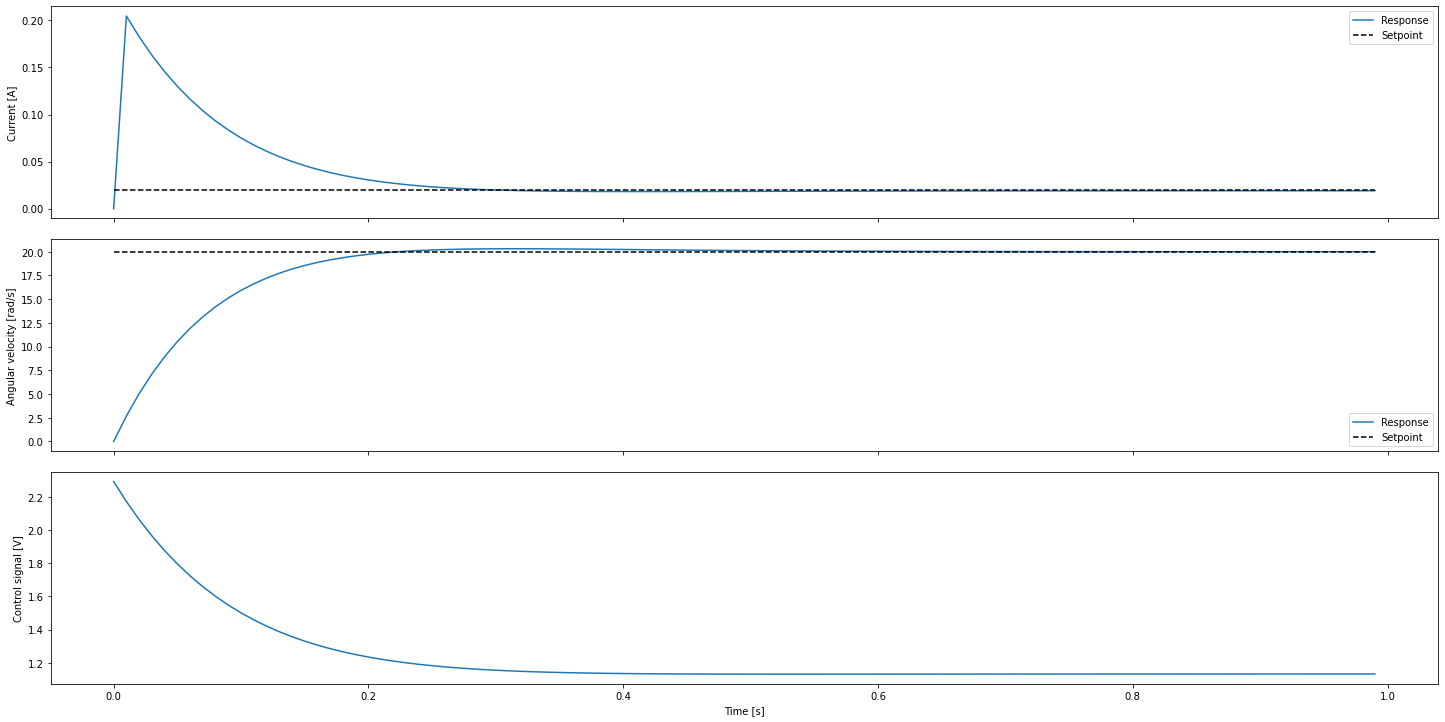

In [25]:
dt = 0.01
T_d = 1.0
T = np.arange(0, T_d, dt)

# create auxiliary LTI to compute K matrix
# since integrated velocity is position assume position is state variable
A = np.array([
    [-R / mwL,      -mwKe / mwL,  0.0],
    [ mwkt / mm.Jm, -mwKd / mmJm, 0.0],
    [0.0,            1.0,         0.0]
])

B = np.array([
    [1.0 / mwL],
    [0.0],
    [0.0]
])

# only position and velocity are observable
C = np.zeros((2,3))
C[0,0] = 1.0
C[1,2] = 1.0

# create system
sys = ct.matlab.ss(A, B, C, 0)

# initialise weights
Q = np.identity(3)
Q[0,0] = 0.1
Q[1,1] = 0.1
Q[2,2] = 10.0
R = np.ones(1) * 10.0

# compute gains
K, S, E = lqr(sys, Q, R)


# create final LTI with velocity integrator added later on
A = np.array([
    [-R / mwL,      -mwKe / mwL ],
    [ mwkt / mm.Jm, -mwKd / mmJm]
])


B = np.array([
    [1.0 / mwL],
    [0.0]
])

# create velocity integrator LTI
A_int = np.zeros((3,3))
B_int = np.zeros((3,2))
B_int[1,1] = 1.0
C_int = np.zeros((3,3))
C_int[2,1] = 1.0
D_int = np.zeros((3,2))
D_int[0,0] = 1.0
D_int[1,1] = 1.0

isys = ct.matlab.ss(A_int, B_int, C_int, D_int)

# create final LTI
C = np.identity(2)
sys = ct.matlab.ss(A, B, C, 0)
# add integrator before gain matrix
iksys = ct.matlab.series(isys, K)
# add both LQI before LTI
ikpsys = ct.matlab.series(iksys, sys)
# create feedback loop
fsys = ct.matlab.feedback(ikpsys, np.identity(2))

# compute response
u = np.ones((len(T), 2))
u[:,0] = 0.02
u[:,1] = 20.0
y, _, _ = lsim(fsys, u, T)
plant_u, _, _ = lsim(iksys, u-y, T)


fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20, 10))
fig.tight_layout()
axs[0].plot(T, y[:,0])
axs[0].plot(T, u[:,0], 'k--')
axs[0].legend(['Response', 'Setpoint'])
axs[0].set_ylabel('Current [A]')

axs[1].plot(T, y[:,1])
axs[1].plot(T, u[:,1], 'k--')
axs[1].legend(['Response', 'Setpoint'])
axs[1].set_ylabel('Angular velocity [rad/s]')

axs[2].plot(T, plant_u)
axs[2].set_ylabel('Control signal [V]')
axs[2].set_xlabel('Time [s]')

As it can be seen this resulted in much batter final response

# Discrete LQI

In order to evaluate system performance in real world application whole control loop was discretized

/tmp/ipykernel_92033/2227262573.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([
/tmp/ipykernel_92033/2227262573.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([


Text(0.5, 69.0, 'Time [s]')

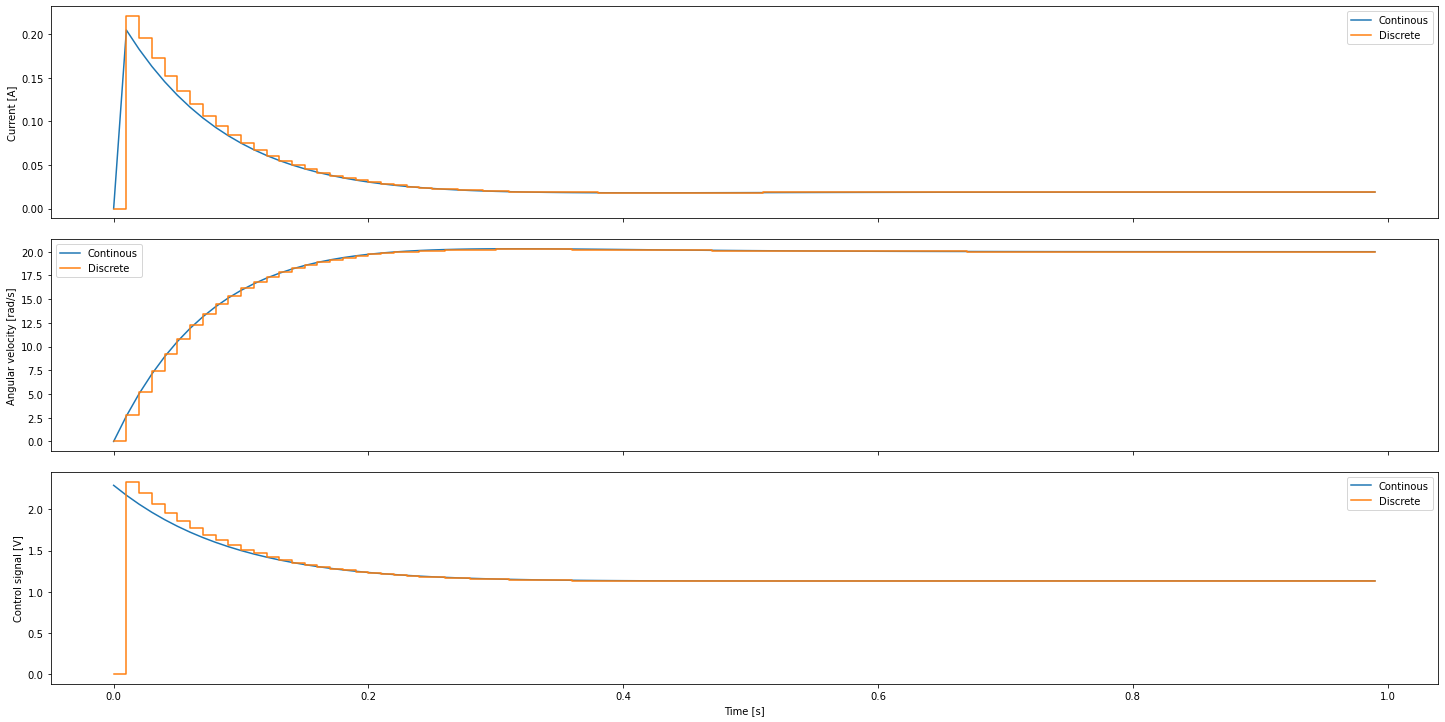

In [26]:
dt = 0.01
T_d = 1.0
T = np.arange(0, T_d, dt)

# crete auxiliary LTI for LQR gains
A = np.array([
    [-R / mwL,      -mwKe / mwL,  0.0],
    [ mwkt / mm.Jm, -mwKd / mmJm, 0.0],
    [0.0,            1.0,         0.0]
])

B = np.array([
    [1.0 / mwL],
    [0.0],
    [0.0]
])

C = np.zeros((2,3))
C[0,0] = 1.0
C[1,2] = 1.0

# discretize LTI and compute K matrix
sys = ct.matlab.ss(A, B, C, 0)
sysd = ct.matlab.c2d(sys, Ts=dt, method='zoh')
K_d, _, _ = dlqr(sysd, Q, R)

# discretize integrator
isysd = ct.matlab.c2d(isys, Ts=dt, method='zoh')

# create final LTI and make it discrete
A = np.array([
    [-R / mwL,      -mwKe / mwL ],
    [ mwkt / mm.Jm, -mwKd / mmJm]
])

B = np.array([
    [1.0 / mwL],
    [0.0]
])
C = np.identity(2)
sys = ct.matlab.ss(A, B, C, 0)
sysd = ct.matlab.c2d(sys, Ts=dt, method='zoh')

# create memory vector for state variables
xd = np.zeros((T.shape[0], 2))
up = np.zeros((T.shape[0], 1))

# create vector of control imputs
u = np.ones((len(T), 2))
u[:,0] = 0.02
u[:,1] = 20.0

# initialize state vector
ix = np.zeros((3,1))

# iteratively solve for closed loop system
for i in range(1, len(T)):
    ix = (isysd.A @ ix + isysd.B * (u[i,:].reshape(2,1) - xd[i-1,:].reshape(2,1)))
    iy = (isysd.C @ ix + isysd.D * (u[i,:].reshape(2,1) - xd[i-1,:].reshape(2,1)))
    up[i] = K_d @ iy
    xd[i,:] = np.squeeze(sysd.A @ xd[i-1,:].reshape(2,1) + sysd.B * up[i])


fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20, 10))
fig.tight_layout()
axs[0].plot(T, y[:,0])
axs[0].step(T, xd[:,0], where='post')
axs[0].legend(['Continous', 'Discrete'])
axs[0].set_ylabel('Current [A]')

axs[1].plot(T, y[:,1])
axs[1].step(T, xd[:,1], where='post')
axs[1].legend(['Continous', 'Discrete'])
axs[1].set_ylabel('Angular velocity [rad/s]')

axs[2].plot(T, plant_u)
axs[2].step(T, up, where='post')
axs[2].legend(['Continous', 'Discrete'])
axs[2].set_ylabel('Control signal [V]')
axs[2].set_xlabel('Time [s]')

# LQG / LQI

Mix of discrete Linear Quadratic Gaussian and Linear Quadratic Integrator in a discrete scenario as it would be used in real application.

/tmp/ipykernel_92033/2603776183.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([


Text(0.5, 68.99999999999991, 'Time [s]')

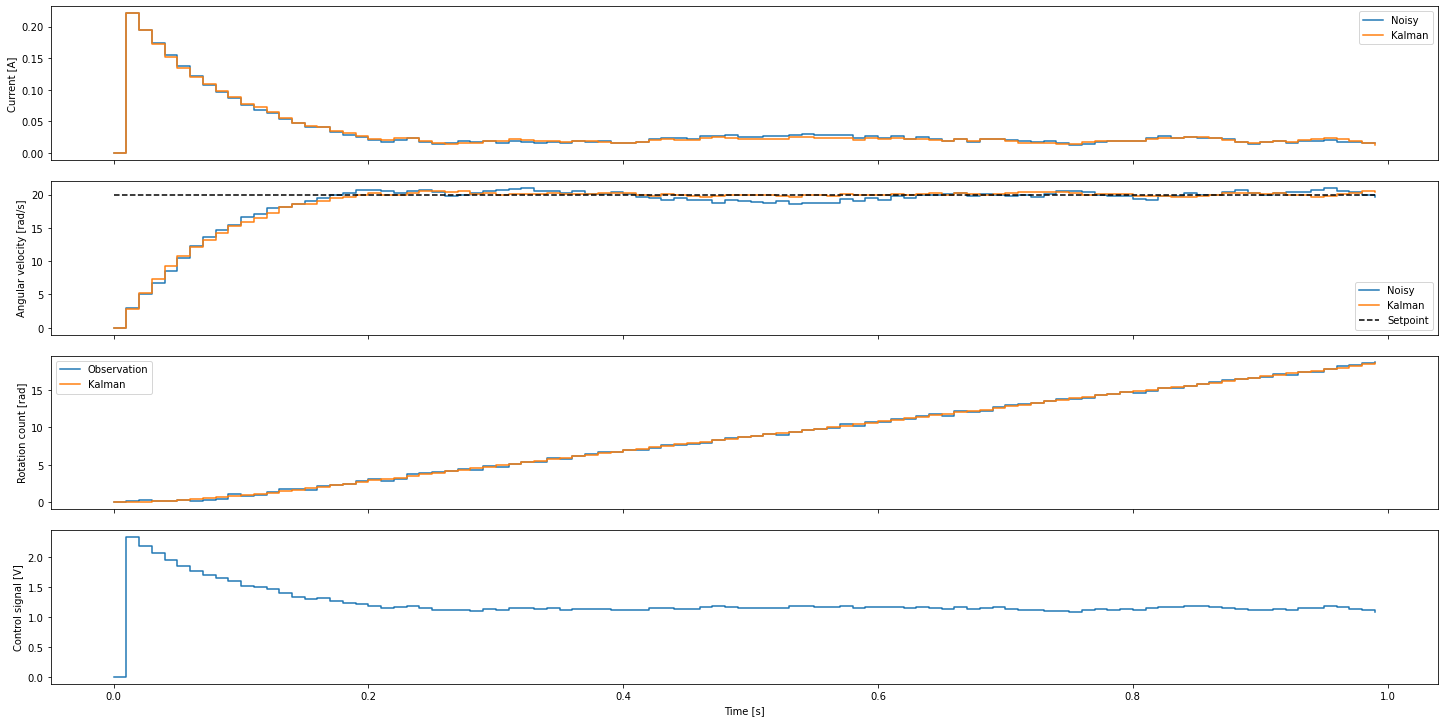

In [27]:
dt = 0.01
T_d = 1.0
T = np.arange(0, T_d, dt)

# create auxiliary LTI for LQR 
A = np.array([
    [-R / mwL,      -mwKe / mwL,  0.0],
    [ mwkt / mm.Jm, -mwKd / mmJm, 0.0],
    [0.0,            1.0,         0.0]
])

B = np.array([
    [1.0 / mwL],
    [0.0],
    [0.0]
])

# KF is reconstructing velocity based on position measurement
C = np.zeros((1,3))
C[-1,-1] = 1.0

# discretize LTI
sys = ct.matlab.ss(A, B, C, 0)
sysd = ct.matlab.c2d(sys, Ts=dt, method='zoh')

# initialise KF with discretized LTI
Q = np.identity(A.shape[0])
Q[0,0] = popt_kf[0]
Q[1,1] = popt_kf[1]
Q[2,2] = popt_kf[2]
R = np.identity(C.shape[0]) * popt_kf[3]
kf = KalmanFilter(sysd.A, sysd.B, sysd.C, Q, R)

# create control input array
u = np.ones((len(T), 2))
u[:,0] = 0.02
u[:,1] = 20.0

# create empty arrays to keep system state over time
xd = np.zeros((T.shape[0], 3))
xk = np.zeros((T.shape[0], 3))
yd = np.zeros((T.shape[0], 1))
up = np.zeros((T.shape[0], 1))
ix = np.zeros((3,1))

# process and measurement noises
c_noise = 0.5
vel_process_noise = 1.0

# compute system response
for i in range(1, len(T)):
    ix = (isysd.A @ ix + isysd.B * (u[i,:].reshape(2,1) - xk[i-1,:2].reshape(2,1)))
    iy = (isysd.C @ ix + isysd.D * (u[i,:].reshape(2,1) - xk[i-1,:2].reshape(2,1)))
    up[i] = K_d @ iy
    xd[i,:] = np.squeeze(sysd.A @ xd[i-1,:].reshape(3,1) + sysd.B * up[i])
    # add random process noise
    xd[i,1] += np.random.rand(1)*vel_process_noise - vel_process_noise/2
    # add random observation noise
    yd[i] = np.squeeze(sysd.C @ xd[i,:]) + np.random.rand(1)*c_noise - c_noise/2
    kf(yd[i], up[i])
    xk[i,:] = np.squeeze(kf.x)

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(20, 10))
fig.tight_layout()
axs[0].step(T, xd[:,0], where='post')
axs[0].step(T, xk[:,0], where='post')
axs[0].legend(['Noisy', 'Kalman'])
axs[0].set_ylabel('Current [A]')

axs[1].step(T, xd[:,1], where='post')
axs[1].step(T, xk[:,1], where='post')
axs[1].plot(T, u[:,1], 'k--')
axs[1].legend(['Noisy', 'Kalman', 'Setpoint'])
axs[1].set_ylabel('Angular velocity [rad/s]')

axs[2].step(T, yd, where='post')
axs[2].step(T, xk[:,2], where='post')
axs[2].legend(['Observation', 'Kalman'])
axs[2].set_ylabel('Rotation count [rad]')

axs[3].step(T, up, where='post')
axs[3].set_ylabel('Control signal [V]')
axs[3].set_xlabel('Time [s]')